In [22]:
from pymongo import MongoClient
import pprint

import pandas as pd

# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

import json
import time

In [23]:
# define variables to use for sending requests

# roster_urls = {}
# roster_urls['unc'] = 'https://goheels.com/sports/womens-basketball/roster/'
# roster_urls['duke'] = 'https://goduke.com/sports/womens-basketball/roster/'
# roster_urls['miami'] = 'https://hurricanesports.com/sports/womens-basketball/roster/'
# roster_urls['nc_state'] = 'https://gopack.com/sports/womens-basketball/roster/'

# #List of desired seasons of data - will combine with roster_urls to scrape
# seasons = ['2009-10', '2010-11', '2011-12', '2017-18', '2018-19', '2019-20']

In [24]:
#Grab requests and input into MongoDB - commented out after completing once
client = MongoClient('localhost', 27017)
db = client.wbb2
rosters = db.rosters

# for season in seasons:
#     for team, url in roster_urls.items():
#         r = requests.get(url + season)
#         rosters.insert_one({'team': team,
#                             'season': season,
#                             'html': r.text})
#         time.sleep(2)

At this point I have an object (rosters) that contains all the HTML files containing each team's roster for every season.

Now I need to parse the html but make sure to tie it to the correct team & season.

Fields I want are:
-heights
-names
-positions
-class_yr

Update MongoDB fields to have the keys with the fields you want with values that consist of the parsed out values.

*****Note*****
-Ran into an issue with parsing the data from Mongo.  I saved the html files in mongo using r.content.  R.content saves the files as bytes rather than strings (r.text).  Didn't find a quick solution to deal with bytes so pulled the html again into the 'wbb2' database and saved it using r.text.

--Update--
Turns out the CSS classes are different from the first 3 years versus the last 3 (except Duke), so it would of course turn up blank results if I'm searching for the wrong class tag.  This wasn't apparent the first time because I was checking the oldest seasons as opposed to the last seasons.

-Iterate from the end of the cursor and once the lists fail to populate, use a different scheme for parsing.

Everything here deals with parsing the html using BeautifulSoup and then cleaning the data.

In [25]:
cursor = rosters.find({})
seasons_2 = ['2017-18', '2018-19', '2019-20']
all_teams = []
for item in cursor:
    if item['season'] in seasons_2 or item['team'] == 'duke':
        soup = BeautifulSoup(item['html'], 'html.parser')
        #run parsing code
        heights = [item.text for item in soup.find_all(class_='height')]
        names = [item.text for item in soup.find_all(class_='sidearm-table-player-name')]
        positions = [item.text for item in soup.find_all(class_='rp_position_short')]
        class_yr = [item.text for item in soup.find_all(class_='roster_class')]
        
        #convert heights of string of ft-inches to an integer of inches
        fix_heights = []
        for height in heights:
            fix_heights.append(12*int(height[0]) + int(height[2:]))
        heights = fix_heights
            
        all_teams.append({'team': item['team'],
                          'season': item['season'],
                          'heights': heights,
                          'names': names,
                          'positions': positions,
                          'class_yr': class_yr})
    else:
        soup = BeautifulSoup(item['html'], 'html.parser')
        #run parsing code
        heights = [item.text for item in soup.find_all(class_='sidearm-roster-player-height')]
        first_names = [item.text for item in soup.find_all(class_='sidearm-roster-player-first-name')]
        last_names = [item.text for item in soup.find_all(class_='sidearm-roster-player-last-name')]
        positions = [item.text for item in soup.find_all(class_='sidearm-list-card-details-item sidearm-roster-player-position-short')]
        class_yr = [item.text for item in soup.find_all(class_='sidearm-roster-player-academic-year')]
        
        #code to get first & last names
        names = [item[0] + ' ' + item[1] for item in zip(first_names, last_names)]
        
        #removes duplicate heights
        heights = heights[:len(names)]
        
        #standardize height format
        heights = [item.replace("'","-") for item in heights]
        heights = [item.replace('"', "") for item in heights]
        
        #convert heights of string of ft-inches to an integer of inches
        fix_heights = []
        for height in heights:
            fix_heights.append(12*int(height[0]) + int(height[2:]))
        heights = fix_heights
        
        #remove duplicate class years
        class_yr = class_yr[-len(names):]
        
        #code to only keep characters relating to positions
        fixed_pos = []
        for string in positions:
                new_pos = [letter for letter in string if letter.isupper()]
                if len(new_pos) == 1:
                    fixed_pos.append(new_pos[0])
                else:
                    fixed_pos.append(new_pos[0] + "/" + new_pos[1])
        positions = fixed_pos
    
        #append desired fields to all_teams list
        all_teams.append({'team': item['team'],
                          'season': item['season'],
                          'heights': heights,
                          'names': names,
                          'positions': positions,
                          'class_yr': class_yr})

Need to verify all records were correctly pulled by checking for blanks and storing the teams & indices.

In [26]:
#check for blank teams and the indexes that contain them
blank_teams = []
blank_indices = []
i=0
for item in all_teams:
    if item['heights'] == []:
        blank_teams.append({'team': item['team'],
                            'season': item['season']
        })
        blank_indices.append(i)
        i+=1
    else:
        i+=1

print(blank_indices)
blank_teams

[]


[]

In [27]:
all_teams

[{'team': 'unc',
  'season': '2009-10',
  'heights': [73, 65, 70, 71, 70, 77, 72, 66, 74, 78, 73, 76, 70, 68, 75],
  'names': ['Nyree Williams',
   "She'la White",
   'Trinity Bursey',
   'Candace Wood',
   'Nicole Powell',
   'Chay Shegog',
   'Krista Gross',
   'Cetera DeGraffenreid',
   'Martina Wood',
   'Waltiea Rolle',
   'Laura Broomfield',
   'Cierra Robertson-Warren',
   'Tierra Ruffin-Pratt',
   'Italee Lucas',
   'Jessica Breland'],
  'positions': ['F',
   'G',
   'F',
   'G',
   'G',
   'F/C',
   'G',
   'G',
   'F/C',
   'F/C',
   'F',
   'F',
   'G',
   'G',
   'F'],
  'class_yr': ['Fr.',
   'So.',
   'Sr.',
   'Rs.',
   'Jr.',
   'So.',
   'Fr.',
   'Jr.',
   'Sr.',
   'Fr.',
   'So.',
   'Fr.',
   'Fr.',
   'Jr.',
   'Sr.']},
 {'team': 'duke',
  'season': '2009-10',
  'heights': [68, 69, 69, 72, 72, 73, 74, 72, 73, 76, 77],
  'names': ['Chelsea Hopkins',
   'Shay Selby',
   'Jasmine Thomas',
   'Karima Christmas',
   'Bridgette Mitchell',
   'Joy Cheek',
   'Kathleen Sc

For my statistical study I'm comparing the average heights of each sample (early years vs. later years).  As a result, I need to have only one instance of any player that played more than one season during that 3 year stretch, otherwise they're being counted multiple times.  

In order to do this I'll use sets.

In [28]:
#Separate all_teams into early_teams & later_teams
early_teams = []
late_teams = []
early_years = ['2009-10', '2010-11', '2011-12']

for dic in all_teams:
    if dic['season'] in early_years:
        early_teams.append(dic)
    else:
        late_teams.append(dic)

#Remove duplicates from early_teams and late_teams
#Pull team, name & height and place in separate lists
early_names = []
late_names = []

#for dic in early_teams:
for dic in early_teams:
    for item in zip(dic['names'], dic['heights']):
        early_names.append((dic['team'], item[0], item[1]))
        
for dic in late_teams:
    for item in zip(dic['names'], dic['heights']):
        late_names.append((dic['team'], item[0], item[1]))

#Put items in separated lists in a set to get unique values
early_set = set(early_names)
late_set = set(late_names)

early_set = list(early_set)
late_set = list(late_set)

-It looks like NC State in particular, re-measured their players after one season and now they have more than one listed height.  I took the larger values of the height... may re-do with smaller values to see what impact it may have.

In [29]:
df_early = pd.DataFrame(early_set, columns = ['Team', 'Name', 'Height'])
df_late = pd.DataFrame(late_set, columns = ['Team', 'Name', 'Height'])

In [30]:
df_early = df_early.sort_values(by=['Name', 'Height'])
df_late = df_late.sort_values(by=['Name', 'Height'])

#Remove duplicates - mainly nc_state players that were measured more than once
#firstlate - kept smaller heights for duplicates
#late - kept larger heights for duplicates
df_early = df_early.drop_duplicates(subset='Name', keep='last')
df_firstlate = df_late.drop_duplicates(subset='Name', keep='first')
df_late = df_late.drop_duplicates(subset='Name', keep='last')

In [31]:
print(df_early['Height'].mean())
print(df_late['Height'].mean())
print(df_firstlate['Height'].mean())
df_firstlate[df_firstlate['Team'] == 'nc_state']

71.11363636363636
72.02272727272727
71.97727272727273


,Team,Name,Height
77,nc_state,Aislinn Konig,69
14,nc_state,Akela Maize,77
81,nc_state,Armani Hawkins,70
57,nc_state,Camille Hobby,73
1,nc_state,Chelsea Nelson,74
69,nc_state,DD Rogers,73
40,nc_state,Elissa Cunane,77
45,nc_state,Elle Sutphin,75
16,nc_state,Erika Cassell,74
36,nc_state,Esra McGoldrick,74


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123a68a90>]],
      dtype=object)

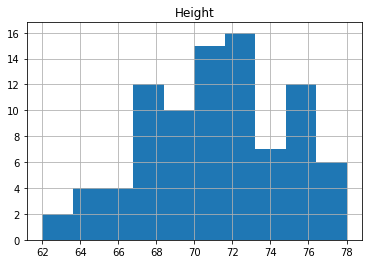

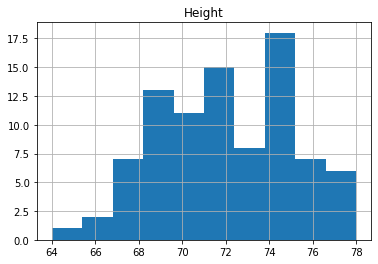

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

df_early.hist(column='Height')
df_late.hist(column='Height')

Histograms show multi-modal distributions.  Since the z-test is based on the normal distribution, the t-test will be a more appropriate test to use.